In [6]:
%load_ext autoreload
%autoreload 2

from gnn_tracking.training.ml import MLModule
from pathlib import Path

from gnn_tracking.utils.loading import TrackingDataModule



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_exchange_path = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange"
)
lmodel = MLModule.load_from_checkpoint(model_exchange_path / "gc" / "gc-7dce6aff.ckpt")

[10:15:40] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[10:15:40] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses


In [7]:

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/"
        ],
        # If you run into memory issues, reduce this
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/"
        ],
        stop=5
    ),
)
dm.setup(stage="fit")

[10:15:49] INFO: DataLoader will load 900 graphs (out of 900 available).
[10:15:49] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21999_s0.pt
[10:15:49] INFO: DataLoader will load 5 graphs (out of 1000 available).
[10:15:49] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29004_s0.pt


In [8]:
data = dm.datasets["val"][0]

out = lmodel(data)
out

{'H': tensor([[ 2.8073, -0.2515, -2.4989,  ...,  1.8979, -0.1762,  1.2323],
         [ 2.1826,  1.2174, -2.1797,  ...,  1.1837, -1.5355,  1.7893],
         [ 2.5277, -0.2892, -1.8901,  ...,  1.9580, -0.4109,  1.4668],
         ...,
         [ 2.7209, -0.2261, -2.8088,  ...,  0.5112,  0.1653,  2.0632],
         [ 1.5343,  0.0773, -2.0842,  ...,  0.4259, -0.3566,  2.9931],
         [ 1.7145,  0.2595, -2.4551,  ...,  0.4925, -0.4575,  2.9908]],
        grad_fn=<MulBackward0>)}

In [9]:
out["H"].shape

torch.Size([59357, 8])

In [59]:
from gnn_tracking.utils.graph_masks import get_good_node_mask
import matplotlib.pyplot as plt

H = out["H"].detach()
h = H.cpu().numpy()
h_oi = h[get_good_node_mask(data)]

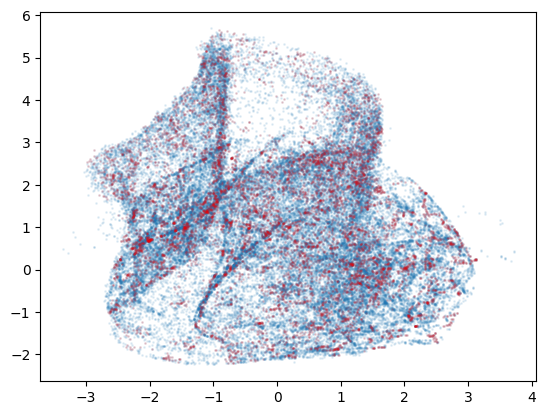

In [65]:

plt.scatter(h[:, 0], h[:, 3], alpha=0.1, s=1)
plt.scatter(h_oi[:, 0], h_oi[:, 3], alpha=0.1, s=1, c="red")

In [113]:
from torch import Tensor as T
import pandas as pd
import numpy as np
from numpy import ndarray as A
import torch

def find_n_split(pids: A, labels: A) -> int:
    df = pd.DataFrame({"pid": pids, "label": labels})
    df = df[df.pid > 0]
    return (df.groupby("pid")["label"].nunique() >= 2).sum() / len(np.unique(pids))


In [91]:
def find_best_split_by_dimension(loader, lmodel):
    values = []
    for data in loader:
        gnm = get_good_node_mask(data)
        doi = data.subgraph(gnm)
        H = lmodel(doi)["H"]
        _values = []
        for i in range(H.shape[1]):
            axis = H[:,i]
            axis -= axis.mean()
            labels = (axis < 0).long()
            _values.append(find_n_split(doi.particle_id, labels.cpu().detach().numpy()))
        values.append(_values)
    means = np.array(values).mean(axis=0)
    errs = np.array(values).std(axis=0) / np.sqrt(len(values))
    return pd.DataFrame({"mean": means, "err": errs})

In [92]:
find_best_split_by_dimension(dm.val_dataloader(), lmodel)

,mean,err
0,0.026539,0.001572
1,0.040637,0.002117
2,0.028234,0.001263
3,0.037601,0.001361
4,0.029067,0.000878
5,0.027933,0.001837
6,0.026505,0.001194
7,0.036574,0.002211


In [93]:
from sklearn.manifold import TSNE

In [95]:
H = lmodel(doi)["H"]

In [97]:
X_embedded = TSNE(n_components=1, learning_rate='auto').fit_transform(H.detach().cpu().numpy())

In [98]:
X_embedded -= X_embedded.mean()

In [130]:
X_embedded = X_embedded.squeeze()

In [161]:
quantiles = np.quantile(X_embedded, np.linspace(0, 1, 12)[1:-1])

In [162]:
labels = torch.zeros_like(doi.particle_id, dtype=torch.int)
for i_quantile, quantile in enumerate(quantiles):
    lower = -np.inf
    upper = np.inf
    if i_quantile > 0:
        lower = quantiles[i_quantile - 1]
    if i_quantile < len(quantiles) - 1:
        upper = quantiles[i_quantile + 1]
    mask = (X_embedded > lower) & (X_embedded < upper)
    labels[mask] = i_quantile

In [163]:
find_n_split(doi.particle_id.detach().cpu().numpy(), labels)

0.0203527815468114

In [164]:
labels.unique().size()

torch.Size([10])

In [167]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(H.detach().cpu().numpy())
labels = kmeans.labels_

In [168]:
find_n_split(doi.particle_id.detach().cpu().numpy(), labels)

0.08344640434192672